In [1]:
# Auto-detect where your Google Drive "eye_project/processed/splits_strict_10cls_new" lives.

from pathlib import Path
import pandas as pd

candidates = [
    Path(r"G:\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\Google Drive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\GoogleDrive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path.home() / "Google Drive" / "My Drive" / "eye_project" / "processed" / "splits_strict_10cls_new",
]

FOUND = None
for p in candidates:
    if (p / "train.csv").exists() and (p / "val.csv").exists() and (p / "test.csv").exists():
        FOUND = p
        break

if FOUND is None:
    # scan a few common drives if quick guesses failed
    for d in ["G","D","E","F","H","I"]:
        root = Path(f"{d}:/")
        if not root.exists(): continue
        try:
            for hit in root.rglob("eye_project/processed/splits_strict_10cls_new/train.csv"):
                folder = hit.parent
                if (folder/"val.csv").exists() and (folder/"test.csv").exists():
                    FOUND = folder
                    break
        except Exception:
            pass
        if FOUND is not None: break

if FOUND is None:
    raise FileNotFoundError("Could not locate splits_strict_10cls_new on this machine.")

print("✅ Found splits folder at:", FOUND)

train_df = pd.read_csv(FOUND / "train.csv")
val_df   = pd.read_csv(FOUND / "val.csv")
test_df  = pd.read_csv(FOUND / "test.csv")
print("Shapes:", train_df.shape, val_df.shape, test_df.shape)

SRC_ROOT = FOUND.parents[1]          # .../eye_project
SRC_RAW  = SRC_ROOT / "raw"
SRC_PROC = SRC_ROOT / "processed"
print("SRC_ROOT:", SRC_ROOT)


✅ Found splits folder at: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project\processed\splits_strict_10cls_new
Shapes: (768, 15) (165, 15) (165, 15)
SRC_ROOT: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project


In [2]:
# Copy referenced images to local SSD and write new local CSVs.

import os, shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm

DST_ROOT   = Path(r"C:\datasets\eye_project")  # local fast SSD
DST_RAW    = DST_ROOT / "raw"
DST_PROC   = DST_ROOT / "processed"
DST_SPLITS = DST_PROC / "splits_strict_10cls_new"

for p in [DST_ROOT, DST_RAW, DST_PROC, DST_SPLITS]:
    p.mkdir(parents=True, exist_ok=True)

# Normalize any lingering Colab paths -> Drive paths
def to_drive_prefix(p: str) -> str:
    return str(p).replace("/content/drive/MyDrive/eye_project", str(SRC_ROOT))

for df in (train_df, val_df, test_df):
    df["img_path"] = df["img_path"].astype(str).apply(to_drive_prefix)

# Unique existing image paths
all_paths = pd.concat([train_df["img_path"], val_df["img_path"], test_df["img_path"]]).unique().tolist()
all_paths = [p for p in all_paths if Path(p).exists()]
print(f"Total images to copy: {len(all_paths):,}")

def rel_under_raw(full_path: Path) -> Path:
    try:
        return full_path.relative_to(SRC_RAW)
    except Exception:
        parts = full_path.parts
        if "raw" in parts:
            i = parts.index("raw")
            return Path(*parts[i+1:])
        return Path(full_path.name)

copied, skipped = 0, 0
for s in tqdm(all_paths, desc="Copying images"):
    src = Path(s)
    rel = rel_under_raw(src)
    dst = DST_RAW / rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst); copied += 1
    else:
        skipped += 1

print(f"Images copied: {copied:,}  (already existed: {skipped:,})")

def to_local_prefix(p: str) -> str:
    return str(p).replace(str(SRC_ROOT), str(DST_ROOT))

def write_local(df: pd.DataFrame, name: str):
    out = df.copy()
    out["img_path"] = out["img_path"].astype(str).apply(to_local_prefix)
    out.to_csv(DST_SPLITS / name, index=False)

write_local(train_df, "train_local.csv")
write_local(val_df,   "val_local.csv")
write_local(test_df,  "test_local.csv")

print("✅ Local CSVs:", DST_SPLITS)

Total images to copy: 1,098


Copying images: 100%|██████████| 1098/1098 [37:34<00:00,  2.05s/it] 

Images copied: 1,098  (already existed: 0)
✅ Local CSVs: C:\datasets\eye_project\processed\splits_strict_10cls_new


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

ROOT_LOCAL = Path(r"C:\datasets\eye_project")
PROC_LOCAL = ROOT_LOCAL / "processed" / "splits_strict_10cls_new"

TRAIN_CSV = PROC_LOCAL / "train_local.csv"
VAL_CSV   = PROC_LOCAL / "val_local.csv"
TEST_CSV  = PROC_LOCAL / "test_local.csv"

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)
train_df.head(3)


Device: cuda
Train/Val/Test: (768, 15) (165, 15) (165, 15)


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_317,317,rfmid1_train,DN,0,0,0,0,0,0,0,0,0,1,C:\datasets\eye_project/raw/RFMiD/Training_Set...
1,rfmid2_train_625,625,rfmid2_train,DR,0,0,0,0,1,0,0,0,0,0,C:\datasets\eye_project/raw/RFMiD2_0/train/625...
2,rfmid1_test_16,16,NaN,ERM,0,0,0,0,0,0,1,0,0,0,C:\datasets\eye_project/raw/RFMiD/Test_Set/Tes...


In [4]:
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision import transforms
from PIL import Image
import torch

# DenseNet121 input: 224x224, ImageNet normalization
transform_dn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        assert "img_path" in self.df.columns, "img_path missing"
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(CLASS_TO_IDX[row["label"]], dtype=torch.long)

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if len(batch) else (torch.empty(0), torch.empty(0, dtype=torch.long))

BATCH_SIZE = 32
PIN_MEMORY = torch.cuda.is_available()

train_ds = FundusDataset(train_df, transform_dn)
val_ds   = FundusDataset(val_df,   transform_dn)
test_ds  = FundusDataset(test_df,  transform_dn)  # for later eval

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)

xb, yb = next(iter(train_dl))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # Expect (32, 3, 224, 224), (32,)

Batch shapes: (32, 3, 224, 224) (32,)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Build DenseNet-121 with torchvision pretrained weights
base = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
# Replace classifier for 10 classes
in_features = base.classifier.in_features  # 1024
base.classifier = nn.Linear(in_features, NUM_CLASSES)

model = base.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("Model ready on:", DEVICE)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 18.0MB/s]


Model ready on: cuda


In [7]:
import time, json
from pathlib import Path

EPOCHS = 50
MODEL_DIR = ROOT_LOCAL / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
DN121_BEST = MODEL_DIR / "densenet121_best.pth"
DN121_HIST = MODEL_DIR / "densenet121_history.json"

def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    if train:
        for xb, yb in dl:
            if xb.nelement() == 0: continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_correct += (out.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0: continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                total_correct += (out.argmax(1) == yb).sum().item()
                total_samples += xb.size(0)

    return (total_loss / max(1,total_samples),
            total_correct / max(1,total_samples))

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time_sec": []}

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    ep_t0 = time.time()
    tr_loss, tr_acc = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc = run_epoch(model, val_dl,   optimizer, criterion, DEVICE, train=False)
    ep_time = time.time() - ep_t0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Epoch time: {ep_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), DN121_BEST)

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f}")

with open(DN121_HIST, "w") as f:
    json.dump(history, f, indent=2)

print("Saved best model  →", DN121_BEST)
print("Saved history     →", DN121_HIST)

Epoch 01/50 | Train Loss: 1.6527, Train Acc: 0.4883 | Val Loss: 1.3167, Val Acc: 0.5515 | Epoch time: 89.8s
Epoch 02/50 | Train Loss: 0.8604, Train Acc: 0.7266 | Val Loss: 1.0100, Val Acc: 0.6485 | Epoch time: 83.1s
Epoch 03/50 | Train Loss: 0.5227, Train Acc: 0.8737 | Val Loss: 0.9122, Val Acc: 0.6909 | Epoch time: 83.9s
Epoch 04/50 | Train Loss: 0.3069, Train Acc: 0.9388 | Val Loss: 0.8358, Val Acc: 0.7515 | Epoch time: 99.0s
Epoch 05/50 | Train Loss: 0.1609, Train Acc: 0.9779 | Val Loss: 0.8611, Val Acc: 0.7455 | Epoch time: 108.2s
Epoch 06/50 | Train Loss: 0.1032, Train Acc: 0.9961 | Val Loss: 0.7890, Val Acc: 0.7455 | Epoch time: 106.8s
Epoch 07/50 | Train Loss: 0.0536, Train Acc: 1.0000 | Val Loss: 0.8393, Val Acc: 0.7455 | Epoch time: 106.3s
Epoch 08/50 | Train Loss: 0.0337, Train Acc: 1.0000 | Val Loss: 0.8529, Val Acc: 0.7394 | Epoch time: 106.3s
Epoch 09/50 | Train Loss: 0.0260, Train Acc: 1.0000 | Val Loss: 0.8198, Val Acc: 0.7697 | Epoch time: 106.5s
Epoch 10/50 | Train Los

✅ Loaded best DenseNet121: C:\datasets\eye_project\models\densenet121_best.pth

✅ Test Accuracy: 0.7273

=== Classification Report (per class) ===
              precision    recall  f1-score   support

        AION     1.0000    0.3333    0.5000         3
        ARMD     0.5000    0.4545    0.4762        11
        BRVO     0.6667    0.5333    0.5926        15
        CRVO     0.8750    0.8750    0.8750         8
          DR     0.8714    0.8592    0.8652        71
         MHL     0.5000    0.5000    0.5000         2
         ERM     0.0000    0.0000    0.0000         2
         ODC     0.6571    0.8846    0.7541        26
        RPEC     0.0000    0.0000    0.0000         3
          DN     0.5385    0.5833    0.5600        24

    accuracy                         0.7273       165
   macro avg     0.5609    0.5023    0.5123       165
weighted avg     0.7175    0.7273    0.7158       165



c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

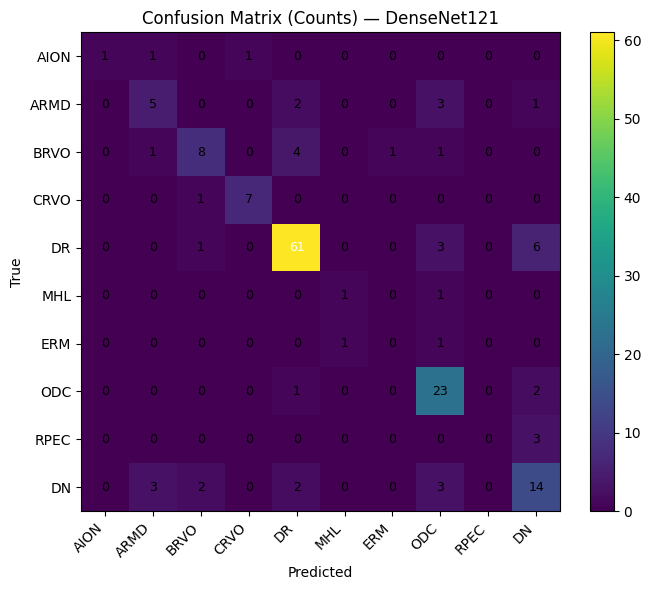


=== ROC–AUC ===
Micro-AUC: 0.9600 | Macro-AUC: 0.9222
AION: 0.9938
ARMD: 0.9421
BRVO: 0.8800
CRVO: 0.9984
DR: 0.9606
MHL: 0.9172
ERM: 0.8712
ODC: 0.9773
RPEC: 0.7942
DN: 0.8871


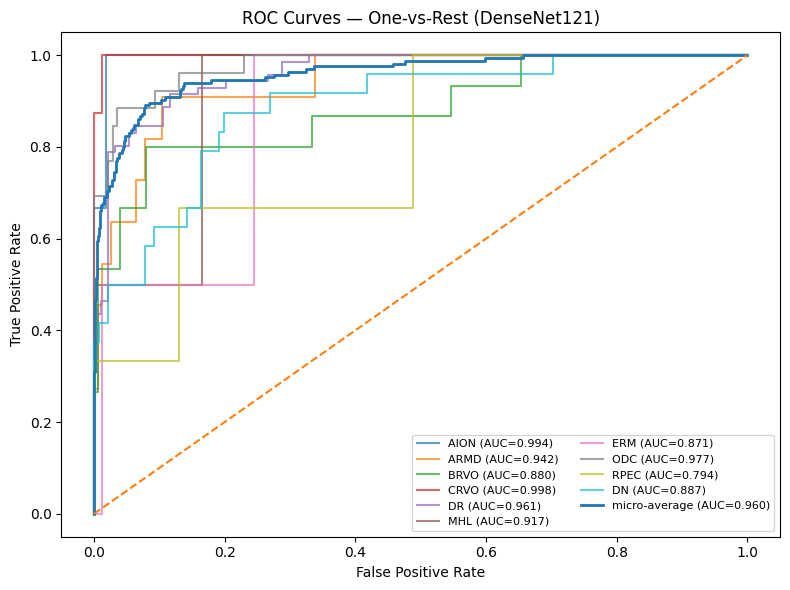

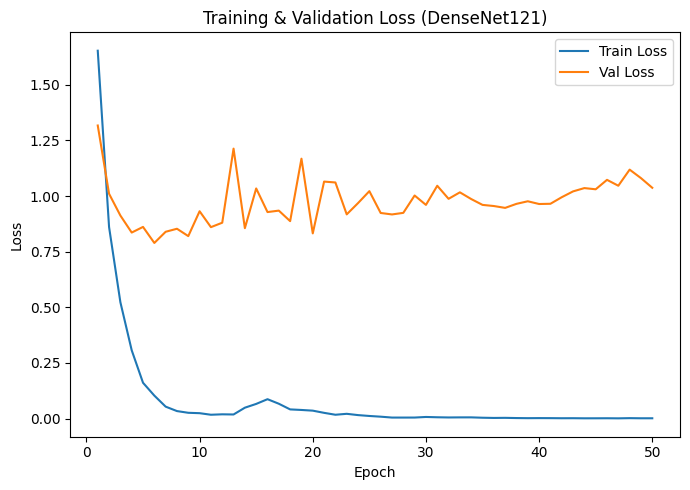

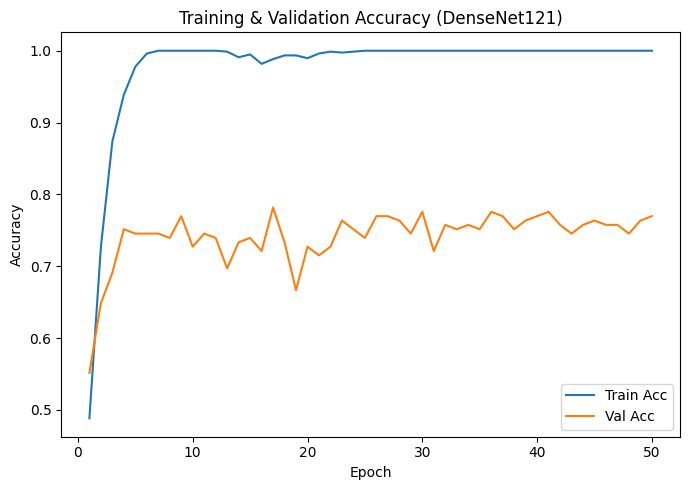

In [8]:
# ==== DenseNet121 — Test Evaluation (Confusion Matrix, Report, ROC–AUC, Curves) ====

import torch
import torch.nn.functional as F
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc
)
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn

MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "densenet121_best.pth"
HIST_PATH = MODEL_DIR / "densenet121_history.json"

NUM_CLASSES = len(CLASSES)

# --- Rebuild DenseNet121 exactly like training (torchvision) and load weights ---
model = densenet121(weights=None)  # no pretrained when loading saved weights
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model = model.to(DEVICE).eval()
print("✅ Loaded best DenseNet121:", CKPT_PATH)

# --- Inference on the test set ---
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        if xb.nelement() == 0:  # safety
            continue
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(yb.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# --- Overall Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# --- Classification Report ---
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# --- Confusion Matrix (with counts) ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Counts) — DenseNet121")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_xticklabels(CLASSES, rotation=45, ha="right")
ax.set_yticklabels(CLASSES)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- ROC–AUC (one-vs-rest) ---
y_true_ovr = np.zeros((y_true.shape[0], NUM_CLASSES), dtype=int)
y_true_ovr[np.arange(y_true.shape[0]), y_true] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_ovr[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average & macro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ovr.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(NUM_CLASSES)])

print("\n=== ROC–AUC ===")
print(f"Micro-AUC: {roc_auc['micro']:.4f} | Macro-AUC: {roc_auc['macro']:.4f}")
for i, cls in enumerate(CLASSES):
    print(f"{cls}: {roc_auc[i]:.4f}")

plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.3f})", alpha=0.7)
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (DenseNet121)")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# --- Training curves from history JSON ---
if HIST_PATH.exists():
    with open(HIST_PATH, "r") as f:
        hist = json.load(f)
    epochs = np.arange(1, len(hist["train_loss"])+1)

    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss (DenseNet121)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training & Validation Accuracy (DenseNet121)")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print(f"\n⚠️ History file not found at {HIST_PATH} — skipping curves.")


In [ ]:
# ==== SHAP for DenseNet121 (similar style to your ResNet Grad-CAM code) ====

# 0) Imports / setup
import os, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms

# Try shap, auto-install if missing
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

# 1) Paths & constants (keeps same REPORT_DIR pattern)
REPORT_DIR = Path(r"C:\datasets\eye_project\reports\densenet121_shap")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path(r"C:\datasets\eye_project\models")
CKPT_PATH = MODEL_DIR / "densenet121_best.pth"  # adjust if your filename differs

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASSES)  # assumes CLASSES exists in notebook

# 2) Build model & load weights (like your style)
try:
    _ = dnet
    _ = dnet.state_dict()
except NameError:
    import timm
    dnet = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
    state = torch.load(CKPT_PATH, map_location=DEVICE)
    dnet.load_state_dict(state)
dnet.eval()

# 3) Preprocessing must match training (same as you used)
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Helper: forward wrapper that outputs logits (torch) — SHAP/GradientExplainer expects model-like callable
def model_forward(x: torch.Tensor):
    # x: torch.Tensor on DEVICE with shape (batch, C, H, W)
    # returns torch.Tensor with shape (batch, num_classes)
    with torch.no_grad():
        out = dnet(x)
    return out

# 4) Prepare SHAP GradientExplainer with a small background set
#    We build background from a small random sample of training/test images (up to 10)
def build_background_paths(max_bg=10):
    # try to sample from test_df or train_df; fallback: random images from REPORT_DIR (if any)
    bg_paths = []
    if 'train_df' in globals():
        src = train_df
    elif 'test_df' in globals():
        src = test_df
    else:
        src = None

    if src is not None:
        all_paths = src["img_path"].values
        # take up to max_bg first (or random sample if you prefer)
        idx = np.random.RandomState(0).choice(len(all_paths), size=min(max_bg, len(all_paths)), replace=False)
        bg_paths = [all_paths[i] for i in idx]
    else:
        # fallback: try to find jpg/png in MODEL_DIR
        files = list(MODEL_DIR.glob("**/*.jpg")) + list(MODEL_DIR.glob("**/*.png"))
        if files:
            bg_paths = [str(p) for p in files[:max_bg]]
    return bg_paths

bg_paths = build_background_paths(max_bg=8)
if len(bg_paths) == 0:
    raise RuntimeError("No background images found for SHAP. Provide train_df/test_df or set build_background_paths to point to images.")

# Build background tensor (shape: B, C, H, W) on DEVICE
bg_tensors = []
for p in bg_paths:
    pil = Image.open(p).convert("RGB")
    t = preproc(pil).unsqueeze(0)
    bg_tensors.append(t)
bg = torch.cat(bg_tensors, dim=0).to(DEVICE)

# Create the SHAP GradientExplainer
# Note: gradient explainer works better using model output logits; pass model_forward wrapper
explainer = shap.GradientExplainer(model_forward, bg)  # heavy object; reuse for multiple images

# 5) shap_for_image helper (saves overlay similarly to your gradcam function)
def shap_for_image(img_path, target="pred", alpha=0.5, nsamples=50):
    """
    img_path: str or Path
    target: "pred" to explain predicted class, or integer class index
    alpha: overlay alpha
    nsamples: number of samples used by shap to estimate gradients (controls speed/quality)
    returns: (fig, pred_idx, probs) and saves PNG to REPORT_DIR
    """
    pil = Image.open(img_path).convert("RGB")
    x = preproc(pil).unsqueeze(0).to(DEVICE)  # shape (1,C,H,W)

    # Forward pass for prediction
    with torch.no_grad():
        logits = dnet(x)
        probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
        pred_idx = int(np.argmax(probs))

    target_idx = pred_idx if target == "pred" else int(target)

    # SHAP attribution: shap_values will be a list (one per output class) or an array shape (num_classes, batch, H, W, C)
    # Use explainer.shap_values; nsamples controls estimation (higher = slower but smoother)
    # Note: shap expects numpy arrays; pass torch tensor moved to CPU as numpy or let shap handle torch tensors (it supports both)
    # We'll pass a torch tensor on DEVICE and let explainer handle it (GradientExplainer is compatible).
    try:
        shap_vals = explainer.shap_values(x, nsamples=nsamples)
    except Exception as e:
        # Sometimes shap API differs; try converting to numpy
        shap_vals = explainer.shap_values(x.cpu().numpy(), nsamples=nsamples)

    # shap_vals may be:
    #  - a list of length num_classes, each item shape (batch, H, W, C) or (batch, C, H, W)
    #  - or a single numpy array (num_classes, batch, H, W, C)
    # Normalize handling:
    # prefer shap_map as (C, H, W) or (H, W, C) for a single image
    if isinstance(shap_vals, list):
        # shap_vals[target_idx] -> array
        arr = np.array(shap_vals[target_idx])  # shape (batch, H, W, C) OR (batch, C, H, W)
    else:
        arr = np.array(shap_vals[target_idx])  # if shap_vals is array (num_classes, batch, ...)
    # extract batch=0
    if arr.ndim == 4:
        # guess shape: (1, H, W, C) or (1, C, H, W)
        a = arr[0]
        if a.shape[0] in (1,3) and a.shape[-1] not in (1,3):
            # likely (C, H, W)
            shap_map = a
        elif a.shape[-1] in (1,3):
            # (H, W, C)
            shap_map = np.transpose(a, (2,0,1))  # to (C,H,W)
        else:
            # fallback: try to permute if needed
            shap_map = a.transpose(2,0,1) if a.shape[-1] in (1,3) else a
    elif arr.ndim == 5:
        # shape maybe (num_classes, batch, H, W, C) handled earlier — try to select batch 0
        a = arr[:,0]  # shape (H,W,C) or (C,H,W)
        shap_map = a
    else:
        raise RuntimeError(f"Unexpected shap output shape {arr.shape}")

    # Now shap_map should be (C, H, W) or (H,W,C) — ensure (C,H,W)
    if shap_map.shape[0] not in (1,3):
        # maybe currently (H,W,C)
        if shap_map.ndim == 3 and shap_map.shape[2] in (1,3):
            shap_map = np.transpose(shap_map, (2,0,1))

    # Aggregate channels: sum absolute values across channels -> heat (H,W)
    heat = np.sum(np.abs(shap_map), axis=0)  # (H, W)
    # Resize heat to input size (should already be 224x224). If not, interpolate.
    # Normalize to [0,1]
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    # Plot/save same style as gradcam_for_image
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(pil); ax[0].set_title("Original"); ax[0].axis("off")

    ax[1].imshow(pil)
    ax[1].imshow(heat, cmap="jet", alpha=alpha)
    ttl = f"SHAP | Pred: {CLASSES[pred_idx]} ({probs[pred_idx]:.2f})"
    if isinstance(target, int):
        ttl += f" | Target: {CLASSES[target]}"
    ax[1].set_title(ttl)
    ax[1].axis("off")
    plt.tight_layout()

    out_name = f"{Path(img_path).stem}_pred-{CLASSES[pred_idx]}_t-{('pred' if target=='pred' else CLASSES[target])}_shap.png"
    out_path = REPORT_DIR / out_name
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    return fig, pred_idx, probs

# 6) Build/refresh pred_df if not present (reuse your approach)
try:
    _ = pred_df
except NameError:
    y_true, y_pred, y_prob, paths = [], [], [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            if xb.nelement() == 0: continue
            # align with test_df ordering as you did earlier
            paths.extend([p for p in test_df["img_path"].iloc[len(y_true):len(y_true)+len(yb)].tolist()])
            xb = xb.to(DEVICE)
            logits = dnet(xb)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            y_prob.append(probs)
            y_pred.append(probs.argmax(1))
            y_true.append(yb.numpy())
    import pandas as pd
    y_prob = np.concatenate(y_prob, 0); y_pred = np.concatenate(y_pred, 0); y_true = np.concatenate(y_true, 0)
    pred_df = pd.DataFrame({
        "img_path": test_df["img_path"].values,
        "true_idx": y_true,
        "pred_idx": y_pred,
        "true_label": [CLASSES[i] for i in y_true],
        "pred_label": [CLASSES[i] for i in y_pred],
        "correct": (y_true == y_pred).astype(int),
    })

# 7) Pick N hard misclassifications and plot SHAP overlays (same ranking strategy)
N = 8
def conf_for_row_shap(row):
    # recompute prob for that image quickly (ensures alignment if pred_df not fresh)
    pil = Image.open(row["img_path"]).convert("RGB")
    x = preproc(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pr = F.softmax(dnet(x), dim=1)[0].cpu().numpy()
    return float(pr[row["pred_idx"]])

mis = pred_df[pred_df["correct"] == 0].copy()
if len(mis) > 0:
    mis["wrong_conf"] = mis.apply(conf_for_row_shap, axis=1)
    sel = mis.sort_values("wrong_conf", ascending=False).head(N)
    print(f"Showing SHAP for {len(sel)} most confident misclassifications...")
    cols = 2
    rows = math.ceil(len(sel) / cols)
    plt.figure(figsize=(cols*8, rows*4.5))
    for i, (_, r) in enumerate(sel.iterrows(), start=1):
        plt.subplot(rows, cols, i)
        fig, pred_idx, probs = shap_for_image(r["img_path"], target="pred", alpha=0.5, nsamples=50)
        plt.close(fig)  # saved to disk already
        img_show = Image.open(REPORT_DIR / f"{Path(r['img_path']).stem}_pred-{CLASSES[pred_idx]}_t-pred_shap.png")
        plt.imshow(img_show); plt.axis("off")
        plt.title(f"T:{r['true_label']} | P:{r['pred_label']}")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found — showing a few correct predictions instead.")
    corr = pred_df[pred_df["correct"] == 1].sample(4, random_state=0)
    for _, r in corr.iterrows():
        shap_for_image(r["img_path"], target="pred", alpha=0.5, nsamples=50)


In [6]:
# ==== SHAP explainability for your DenseNet121 image classifier ====
import os
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Assumptions (from your existing script)
# - `model` is the trained PyTorch model (on DEVICE), already loaded and set to eval()
# - `train_dl`, `test_dl` exist and produce (tensor_images, labels) where images are normalized
# - `CLASSES` list exists
# - `DEVICE` is set ('cuda' or 'cpu')

model.eval()

# ---- Helpers: convert between formats ----
def tensor_to_numpy_imgs(tensor): 
    """
    Input: PyTorch tensor in shape (N, C, H, W), normalized, on CPU or GPU
    Output: numpy array shape (N, H, W, C) float32 (channel-last) - same values model sees
    """
    if isinstance(tensor, torch.Tensor):
        arr = tensor.detach().cpu().numpy()
    else:
        arr = np.array(tensor)
    # convert to HWC for plotting functions
    arr = np.transpose(arr, (0, 2, 3, 1))
    return arr.astype(np.float32)

def numpy_to_tensor(nparr):
    """Convert numpy (N, C, H, W) -> torch tensor on DEVICE"""
    t = torch.from_numpy(nparr).to(DEVICE)
    return t

# Wrapper predict function for SHAP if needed (accepts numpy in channel-first: N,C,H,W)
def predict_numpy_channel_first(x_numpy):
    """
    x_numpy: numpy array shape (N, C, H, W), dtype float32, same normalization as training.
    returns: numpy probabilities shape (N, num_classes)
    """
    model.eval()
    with torch.no_grad():
        # ensure float32
        x = torch.from_numpy(x_numpy.astype(np.float32)).to(DEVICE)
        out = model(x)
        probs = torch.nn.functional.softmax(out, dim=1).cpu().numpy()
    return probs

# ---- Build background (small!) ----
# Use a small sample from train_dl: 25-100 examples recommended depending on RAM.
BACKGROUND_SIZE = 50   # lower if memory constrained (10-30)
background_list = []
count = 0
for xb, yb in train_dl:
    if xb.nelement() == 0: 
        continue
    # take from first batches
    to_take = min(BACKGROUND_SIZE - count, xb.shape[0])
    if to_take <= 0:
        break
    background_list.append(xb[:to_take].detach().cpu())
    count += to_take
    if count >= BACKGROUND_SIZE:
        break

if len(background_list) == 0:
    raise RuntimeError("Could not build background from train_dl (empty).")

background_tensor = torch.cat(background_list, dim=0)  # shape (M, C, H, W)
background_numpy_cf = background_tensor.numpy()        # channel-first numpy (M, C, H, W)

print("Background shape (numpy, channel-first):", background_numpy_cf.shape)

# ---- Pick a small set from test_dl to explain ----
EXPLAIN_N = 4   # explain 1-8 images at a time; keep small
test_batch = None
for xb, yb in test_dl:
    if xb.nelement() == 0:
        continue
    test_batch = xb[:EXPLAIN_N].detach().cpu()
    test_labels = yb[:EXPLAIN_N].cpu().numpy()
    break

if test_batch is None:
    raise RuntimeError("test_dl yielded no batches to explain.")

test_numpy_cf = test_batch.numpy()  # (N, C, H, W)
print("Test explain batch shape (channel-first):", test_numpy_cf.shape)

# ---- Try GradientExplainer (preferred for PyTorch models) ----
# We give explainer the model via a wrapper predict function and the background as numpy (channel-first).
try:
    print("Attempting shap.GradientExplainer (fast for differentiable models)...")
    # Note: shap.GradientExplainer often accepts a model object directly in newer SHAP versions,
    # but using a wrapper predict function + background numpy is robust across versions.
    # We'll use the callable predict_numpy_channel_first as the 'model' and background numpy.
    explainer = shap.GradientExplainer(predict_numpy_channel_first, background_numpy_cf)
    # shap_values shape for multiclass: list of arrays (one per class) each (N, C, H, W) OR array depending on SHAP version
    shap_values = explainer.shap_values(test_numpy_cf)
    print("GradientExplainer completed.")
except Exception as e:
    print("GradientExplainer failed (falling back to KernelExplainer). Error:", e)
    # Fallback to KernelExplainer (model-agnostic) — slower and needs much smaller background
    # Use very small background (e.g., 10 examples) and small nsamples to be feasible
    small_bg = background_numpy_cf[:10]  # (m, C, H, W)
    # KernelExplainer expects 2D inputs usually; flatten images to 1D per sample
    bg_flat = small_bg.reshape(small_bg.shape[0], -1)
    test_flat = test_numpy_cf.reshape(test_numpy_cf.shape[0], -1)

    def predict_flat(x_flat):
        # x_flat: (N, D) where D = C*H*W
        x = x_flat.reshape((x_flat.shape[0],) + (background_numpy_cf.shape[1:]))  # (N, C, H, W)
        return predict_numpy_channel_first(x)

    explainer = shap.KernelExplainer(predict_flat, bg_flat)
    shap_vals_flat = explainer.shap_values(test_flat, nsamples=100)  # adjust nsamples for quality/time
    # reshape back to (classes, N, C, H, W) or (N, C, H, W) depending on output
    # KernelExplainer for multiclass returns list per class of shape (N, D). We'll reshape:
    if isinstance(shap_vals_flat, list):
        # each item is (N, D)
        shap_values = [sv.reshape((sv.shape[0],) + background_numpy_cf.shape[1:]) for sv in shap_vals_flat]
    else:
        shap_values = shap_vals_flat.reshape((shap_vals_flat.shape[0],) + background_numpy_cf.shape[1:])

# ---- Prepare images for plotting (SHAP's image_plot expects channel-last HWC) ----
# test_images_hwc: shape (N, H, W, C)
test_images_hwc = tensor_to_numpy_imgs(test_batch)

# shap_values: could be (classes, N, C, H, W) or list of length classes each (N,C,H,W)
# For shap.image_plot we want a list where each element is an array shaped (N, H, W, C) or similar.
# Convert/shuffle axes as necessary.
def convert_shap_to_imageplot_format(shap_vals):
    """
    Accepts:
    - list_of_arrays: list length = num_classes; each array shape (N, C, H, W)
    - or an array shape (num_classes, N, C, H, W) or (N, C, H, W)
    Returns:
    - list_for_image_plot: list of arrays length = num_classes; each (N, H, W, C)
    """
    if isinstance(shap_vals, list):
        out = []
        for arr in shap_vals:
            arr = np.array(arr)  # (N, C, H, W)
            arr = np.transpose(arr, (0, 2, 3, 1))  # -> (N, H, W, C)
            out.append(arr)
        return out
    else:
        arr = np.array(shap_vals)
        if arr.ndim == 4:  # (N, C, H, W)
            arr = np.transpose(arr, (0, 2, 3, 1))
            # return list with single element (e.g., for binary/regression)
            return [arr]
        elif arr.ndim == 5:  # (classes, N, C, H, W)
            out = []
            for i in range(arr.shape[0]):
                a = arr[i]
                a = np.transpose(a, (0, 2, 3, 1))
                out.append(a)
            return out
        else:
            raise ValueError("Unexpected shap_values shape: " + str(arr.shape))

shap_image_list = convert_shap_to_imageplot_format(shap_values)

# ---- Plot: SHAP image plot for predicted class (or all classes) ----
# Get predicted classes for the test batch (for titles)
with torch.no_grad():
    xb_t = torch.from_numpy(test_numpy_cf.astype(np.float32)).to(DEVICE)
    logits = model(xb_t)
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
preds = probs.argmax(axis=1)

# Plot SHAP overlays. shap.image_plot expects list-of-arrays per class then images HWC.
# We'll plot for the predicted class of each image (if multi-class we pick predicted class index)
for i in range(test_images_hwc.shape[0]):
    pred_cls = preds[i]
    plt.figure(figsize=(6,6))
    plt.title(f"Sample {i} — True: {CLASSES[test_labels[i]]} | Pred: {CLASSES[pred_cls]}")
    try:
        # shap.image_plot will visualize for class index if we pass list-of-class-arrays
        # It plots all images in the batch; we pass single sample lists for clarity:
        single_shap_for_each_class = [arr[i:i+1] for arr in shap_image_list]  # each (1,H,W,C)
        single_image = test_images_hwc[i:i+1]  # (1,H,W,C)
        # Show the shap overlay for predicted class only by indexing that list
        # shap.image_plot expects either (list-of-class-arrays, images) and will display them.
        # For clarity we call image_plot on the list-of-class-arrays with images; to focus on pred class, show that subplot title.
        shap.image_plot(single_shap_for_each_class, single_image)
    except Exception as e:
        print("shap.image_plot failed for sample", i, "error:", e)
        # fallback: show raw image
        plt.imshow((single_image[0] - single_image[0].min()) / (single_image[0].ptp() + 1e-9))
    plt.show()

# ---- Save SHAP arrays for later analysis ----
OUT_DIR = Path(r"C:\datasets\eye_project\shap_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save shap arrays (convert to channel-first for compactness)
np.save(OUT_DIR / "shap_values_sample_batch.npy", shap_values)  # careful: may be list; np.save handles lists via object arrays
np.save(OUT_DIR / "test_images_hwc.npy", test_images_hwc)
np.save(OUT_DIR / "preds.npy", preds)
print("Saved SHAP outputs to:", OUT_DIR)

print("Done. You can increase EXPLAIN_N or BACKGROUND_SIZE when you have more memory/time.")


ModuleNotFoundError: No module named 'shap'

In [1]:
# ==== DenseNet121 SHAP XAI Toolkit (Final, Complete) ====

import numpy as np, pandas as pd, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from pathlib import Path
import shap

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']  # adjust to your labels
NUM_CLASSES = len(CLASSES)

ROOT = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "densenet121_best.pth"
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- DATA ----------------
test_df = pd.read_csv(TEST_CSV)
print("Test rows:", len(test_df))

# ---------------- MODEL ----------------
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval().to(DEVICE)
print("✅ Loaded:", CKPT_PATH)

# ---------------- PREPROCESS ----------------
def make_preproc(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
preproc_224 = make_preproc(224)

# ---------------- HELPERS ----------------
def predict_probs(pil_img, preproc=preproc_224):
    x = preproc(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1)[0].cpu().numpy()
    return x, probs, int(np.argmax(probs))

def normalize01(a):
    a = a - a.min()
    return a / (a.max() + 1e-8)

# ---------------- SHAP EXPLAINER ----------------
# Wrap model for SHAP: expects numpy (H,W,C) in batch
def model_forward(x_numpy):
    x_tensor = torch.tensor(x_numpy.transpose(0,3,1,2), dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

def shap_explain(pil_img, background=None):
    x, probs, pred_idx = predict_probs(pil_img)
    img_np = x.cpu().numpy().transpose(0,2,3,1)  # (1,H,W,C)

    if background is None:
        background = img_np  # use the same image as background

    explainer = shap.Explainer(model_forward, background)
    shap_values = explainer(img_np)

    heat = shap_values.values[0].mean(axis=-1)  # average across channels
    heat = normalize01(heat)
    return probs, pred_idx, heat

# ---------------- VISUALIZATION ----------------
def panel_shap(img_path, save_prefix="shap"):
    pil = Image.open(img_path).convert("RGB")
    probs, pred_idx, heat = shap_explain(pil)
    pred_lbl, pred_conf = CLASSES[pred_idx], probs[pred_idx]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pil)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(pil)
    ax[1].imshow(heat, cmap="jet", alpha=0.5)
    ax[1].set_title("SHAP Heatmap")
    ax[1].axis("off")

    fig.suptitle(f"Pred: {pred_lbl} ({pred_conf:.2f})")
    plt.tight_layout(rect=[0,0,1,0.92])

    out = OUT_DIR / f"{Path(img_path).stem}_{save_prefix}.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", out)

# ---------------- RUN ON SAMPLE ----------------
sample = test_df.sample(1, random_state=42).iloc[0]["img_path"]
print("Explaining:", sample)
panel_shap(sample)


ModuleNotFoundError: No module named 'shap'

In [2]:
pip install shap



SyntaxError: invalid syntax (1357195708.py, line 1)

In [3]:
!pip install shap


   ---------------------------------------- 0.0/547.0 kB ? eta -:--:--
   ---------------------------------------- 547.0/547.0 kB 17.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 17.6 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---- ----------------------------------- 3.9/38.1 MB 19.5 MB/s eta 0:00:02
   -------- ------------------------------- 8.1/38.1 MB 19.3 MB/s eta 0:00:02
   ------------- -------------------------- 12.6/38.1 MB 19.2 MB/s eta 0:00:02
   ----------------- ---------------------- 16.8/38.1 MB 19.6 MB/s eta 0:00:02
   --------------------- ------------------ 20.2/38.1 MB 19.0 MB/s eta 0:00:01
   ----------------------- ---------------- 22.0/38.1 MB 17.4 MB/s eta 0:00:01
   --------------------------- ------------ 26.2/38.1 MB 17.5 MB/s eta 0:00:01
   ------------------------------- -------- 30.4/38.1 MB 17.7 MB/s eta 0:00:01
   -----

In [4]:
# ==== DenseNet121 SHAP XAI Toolkit (Final, Complete) ====

import numpy as np, pandas as pd, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from pathlib import Path
import shap

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']  # adjust to your labels
NUM_CLASSES = len(CLASSES)

ROOT = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "densenet121_best.pth"
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- DATA ----------------
test_df = pd.read_csv(TEST_CSV)
print("Test rows:", len(test_df))

# ---------------- MODEL ----------------
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval().to(DEVICE)
print("✅ Loaded:", CKPT_PATH)

# ---------------- PREPROCESS ----------------
def make_preproc(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
preproc_224 = make_preproc(224)

# ---------------- HELPERS ----------------
def predict_probs(pil_img, preproc=preproc_224):
    x = preproc(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1)[0].cpu().numpy()
    return x, probs, int(np.argmax(probs))

def normalize01(a):
    a = a - a.min()
    return a / (a.max() + 1e-8)

# ---------------- SHAP EXPLAINER ----------------
# Wrap model for SHAP: expects numpy (H,W,C) in batch
def model_forward(x_numpy):
    x_tensor = torch.tensor(x_numpy.transpose(0,3,1,2), dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

def shap_explain(pil_img, background=None):
    x, probs, pred_idx = predict_probs(pil_img)
    img_np = x.cpu().numpy().transpose(0,2,3,1)  # (1,H,W,C)

    if background is None:
        background = img_np  # use the same image as background

    explainer = shap.Explainer(model_forward, background)
    shap_values = explainer(img_np)

    heat = shap_values.values[0].mean(axis=-1)  # average across channels
    heat = normalize01(heat)
    return probs, pred_idx, heat

# ---------------- VISUALIZATION ----------------
def panel_shap(img_path, save_prefix="shap"):
    pil = Image.open(img_path).convert("RGB")
    probs, pred_idx, heat = shap_explain(pil)
    pred_lbl, pred_conf = CLASSES[pred_idx], probs[pred_idx]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pil)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(pil)
    ax[1].imshow(heat, cmap="jet", alpha=0.5)
    ax[1].set_title("SHAP Heatmap")
    ax[1].axis("off")

    fig.suptitle(f"Pred: {pred_lbl} ({pred_conf:.2f})")
    plt.tight_layout(rect=[0,0,1,0.92])

    out = OUT_DIR / f"{Path(img_path).stem}_{save_prefix}.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", out)

# ---------------- RUN ON SAMPLE ----------------
sample = test_df.sample(1, random_state=42).iloc[0]["img_path"]
print("Explaining:", sample)
panel_shap(sample)


Test rows: 165


c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\datasets\\eye_project\\models\\densenet121_best.pth'

In [3]:
# ================= SHAP XAI — DenseNet121 (robust, targeted or top-pred, batch save) =================
import sys, subprocess, warnings, os
warnings.filterwarnings("ignore")

# --- 0) Install SHAP if missing ---
try:
    import shap
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import timm
from pathlib import Path
from PIL import Image, ImageFile
from torchvision import transforms
import matplotlib.pyplot as plt

# Safer image loading
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ---------------- 1) Config ----------------
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT       = Path(r"C:\datasets\eye_project")
CKPT_PATH  = ROOT / "models" / "densenet121_best.pth"      # <-- change if needed
TEST_CSV   = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR    = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"
assert TEST_CSV.exists(),  f"Test CSV not found: {TEST_CSV}"

# Choose how many images to explain
K_SAMPLES   = 4
# SHAP sampling budget (↑ smoother, ↓ faster)
NSAMPLES    = 300
# Explain top prediction (None) or force a specific class (e.g., "DR")
TARGET_LABEL = None  # set to e.g. "DR" to force that class

# ---------------- 2) Model ----------------
model = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.to(DEVICE).eval()
print("✅ Loaded:", CKPT_PATH)

# Wrap with softmax so SHAP explains probabilities (more interpretable)
class ProbWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.sm = torch.nn.Softmax(dim=1)
    def forward(self, x):
        return self.sm(self.base(x))

wrapped = ProbWrapper(model).to(DEVICE).eval()

# ---------------- 3) Preprocessing / (optional) de-normalization ----------------
IMG_HW = (224, 224)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

preproc = transforms.Compose([
    transforms.Resize(IMG_HW),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.squeeze().tolist(), std=std.squeeze().tolist()),
])

def load_tensor(path_str: str):
    pil = Image.open(path_str).convert("RGB")
    return preproc(pil), pil

def denorm_to_uint8(xb: torch.Tensor):  # xb: (N,3,H,W)
    x = xb.detach().cpu() * std + mean
    x = x.clamp(0,1)
    x = (x.permute(0,2,3,1).numpy() * 255).astype(np.uint8)  # (N,H,W,3)
    return x

# ---------------- 4) Data (test split) ----------------
df = pd.read_csv(TEST_CSV)
df["img_path"] = df["img_path"].apply(lambda p: str(Path(p)))
df = df[df["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
assert len(df) > 0, "Test CSV has no existing img_path rows."

# ---------------- 5) Background set for SHAP (small & diverse) ----------------
BKG_N = min(25, len(df))
bkg_paths = df.sample(BKG_N, random_state=42)["img_path"].tolist()
bkg_tensors = []
for p in bkg_paths:
    try:
        xt, _ = load_tensor(p)
        bkg_tensors.append(xt)
    except Exception:
        pass
assert len(bkg_tensors) > 0, "No background images could be loaded for SHAP!"
background = torch.stack(bkg_tensors, dim=0).to(DEVICE)

# ---------------- 6) Build SHAP Explainer ----------------
# GradientExplainer uses gradients -> efficient for CNNs
explainer = shap.GradientExplainer(wrapped, background)

# ---------------- 7) Select K images & run SHAP ----------------
sample_df = df.sample(min(K_SAMPLES, len(df)), random_state=7).reset_index(drop=True)

for i, row in sample_df.iterrows():
    path = row["img_path"]
    true_label = row.get("label", "?")

    # Load & predict
    xt, pil = load_tensor(path)              # (3,H,W)
    xb = xt.unsqueeze(0).to(DEVICE)          # (1,3,H,W)
    with torch.no_grad():
        probs = wrapped(xb)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    pred_lbl = CLASSES[pred_idx]
    conf = float(probs[pred_idx])

    # Decide which output to explain
    if TARGET_LABEL is None:
        # Explain top predicted class
        shap_values = explainer.shap_values(xb, ranked_outputs=1, nsamples=NSAMPLES)
        # ---- after: shap_values = explainer.shap_values(...)
# build HWC (H, W, 3) safely regardless of SHAP’s return layout
        def shap_to_hwc(sv_block):
    """
    sv_block: np.ndarray for one sample (could be CHW or HWC).
    Returns HWC array.
    """
            if sv_block.ndim != 3:
                raise ValueError(f"Unexpected SHAP value shape: {sv_block.shape}")
    # CHW → HWC
            if sv_block.shape[0] == 3:
                return np.transpose(sv_block, (1, 2, 0))
    # HWC → HWC
            if sv_block.shape[-1] == 3:
                return sv_block
    # Sometimes SHAP returns (1,H,W) per-channel lists. Try to expand/stack if needed.
    # (fallback) try moving first axis to end
            return np.moveaxis(sv_block, 0, -1)

            if TARGET_LABEL is None:
    # ranked_outputs=1 returns list of length 1
                sv_raw = shap_values[0][0]        # one image
                sv = shap_to_hwc(sv_raw)          # (H,W,3)
                title = f"SHAP — Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}"
            else:
                tgt_idx = CLASSES.index(TARGET_LABEL)
                sv_raw = shap_values[tgt_idx][0]
                sv = shap_to_hwc(sv_raw)
                title = f"SHAP — Target: {TARGET_LABEL} | Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}"

        
    else:
        assert TARGET_LABEL in CLASSES, f"Unknown TARGET_LABEL: {TARGET_LABEL}"
        tgt_idx = CLASSES.index(TARGET_LABEL)
        shap_values = explainer.shap_values(xb, ranked_outputs=None, nsamples=NSAMPLES)
        # shap_values is a list of arrays, one per class
        sv = shap_values[tgt_idx][0].transpose(1,2,0)
        title = f"SHAP — Target: {TARGET_LABEL} | Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}"

    # Prepare image for SHAP overlay
    img_uint8 = denorm_to_uint8(xb)[0]  # (H,W,3) uint8 in [0,255]

    # Plot side-by-side: Original | SHAP heatmap
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(pil)
    axes[0].set_title(f"Original\nTrue: {true_label}")
    axes[0].axis("off")

    # shap.image_plot expects lists; supply normalized image [0,1]
    shap.image_plot([sv], [img_uint8 / 255.0], show=False, axes=axes[1:2])
    axes[1].set_title(title)
    plt.tight_layout()

    # Save
    stem = Path(path).stem
    suffix = TARGET_LABEL if TARGET_LABEL is not None else pred_lbl
    out_path = OUT_DIR / f"{stem}_shap_{suffix}.png"
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    print(f"Saved: {out_path}")
    plt.show()

print("✅ Done.")


IndentationError: expected an indented block after function definition on line 132 (493391605.py, line 133)

In [4]:
# ================= SHAP XAI — DenseNet121 (robust, no shap.image_plot, clean overlays) =================
import sys, subprocess, warnings, os
warnings.filterwarnings("ignore")

# --- Install SHAP if missing ---
try:
    import shap
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import timm
from pathlib import Path
from PIL import Image, ImageFile
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Safer image loading for occasional JPEG issues
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ---------------- 1) Config ----------------
CLASSES     = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT       = Path(r"C:\datasets\eye_project")
CKPT_PATH  = ROOT / "models" / "densenet121_best.pth"      # <— change if needed
TEST_CSV   = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR    = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
IMG_HW     = (224, 224)
K_SAMPLES  = 4        # how many test images to explain
NSAMPLES   = 300      # SHAP sampling budget (100 fast … 500+ smoother)
TARGET_LABEL = None   # e.g., "DR" to force that class, or None to explain top-pred

print("Device:", DEVICE)
assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"
assert TEST_CSV.exists(),  f"Test CSV not found: {TEST_CSV}"

# ---------------- 2) Model ----------------
model = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.to(DEVICE).eval()
print("✅ Loaded:", CKPT_PATH)

# Wrap with softmax so SHAP explains probability outputs
class ProbWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.sm = torch.nn.Softmax(dim=1)
    def forward(self, x):
        return self.sm(self.base(x))

wrapped = ProbWrapper(model).to(DEVICE).eval()

# ---------------- 3) Preprocessing & helpers ----------------
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

preproc = transforms.Compose([
    transforms.Resize(IMG_HW),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.squeeze().tolist(), std=std.squeeze().tolist()),
])

def load_tensor(path_str: str):
    pil = Image.open(path_str).convert("RGB")
    return preproc(pil), pil

def denorm_to_uint8(xb: torch.Tensor):  # xb: (N,3,H,W)
    x = xb.detach().cpu() * std + mean
    x = x.clamp(0,1)
    x = (x.permute(0,2,3,1).numpy() * 255).astype(np.uint8)  # (N,H,W,3)
    return x

def shap_to_hwc(sv_block: np.ndarray) -> np.ndarray:
    """
    Convert a single-sample SHAP array to HWC. Handles CHW or HWC.
    sv_block: (3,H,W) or (H,W,3)
    """
    if sv_block.ndim != 3:
        raise ValueError(f"Unexpected SHAP value shape: {sv_block.shape}")
    if sv_block.shape[0] == 3:         # CHW -> HWC
        return np.transpose(sv_block, (1, 2, 0))
    if sv_block.shape[-1] == 3:        # already HWC
        return sv_block
    # Fallback: move first axis to last
    return np.moveaxis(sv_block, 0, -1)

def overlay_diverging(pil_img: Image.Image, sv_hwc: np.ndarray, alpha=0.6, vmax=None):
    """
    Create a diverging SHAP overlay: red=positive contribution, blue=negative.
    sv_hwc: (H,W,3) SHAP per-channel. We reduce to a single signed map by mean.
    """
    base = np.asarray(pil_img).astype(np.float32) / 255.0     # (H,W,3)
    signed = sv_hwc.mean(axis=2)                              # (H,W)
    if vmax is None:
        vmax = np.percentile(np.abs(signed), 99) + 1e-8
    signed = np.clip(signed / vmax, -1.0, 1.0)                # in [-1,1]
    # map [-1,1] -> colormap (seismic)
    cmap = cm.get_cmap("seismic")
    colored = cmap((signed + 1) / 2.0)[..., :3]               # (H,W,3)
    out = (1 - alpha) * base + alpha * colored
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8), signed

# ---------------- 4) Data (test split) ----------------
df = pd.read_csv(TEST_CSV)
df["img_path"] = df["img_path"].apply(lambda p: str(Path(p)))
df = df[df["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
assert len(df) > 0, "Test CSV has no existing img_path rows."

# ---------------- 5) Background set for SHAP ----------------
BKG_N = min(25, len(df))
bkg_paths = df.sample(BKG_N, random_state=42)["img_path"].tolist()
bkg_tensors = []
for p in bkg_paths:
    try:
        xt, _ = load_tensor(p)
        bkg_tensors.append(xt)
    except Exception:
        pass
assert len(bkg_tensors) > 0, "No background images could be loaded for SHAP!"
background = torch.stack(bkg_tensors, dim=0).to(DEVICE)

# ---------------- 6) Build SHAP Explainer ----------------
explainer = shap.GradientExplainer(wrapped, background)

# ---------------- 7) Explain K samples & save ----------------
sample_df = df.sample(min(K_SAMPLES, len(df)), random_state=7).reset_index(drop=True)

for i, row in sample_df.iterrows():
    path = row["img_path"]
    true_label = row.get("label", "?")

    try:
        # Load & predict
        xt, pil = load_tensor(path)              # (3,H,W)
        xb = xt.unsqueeze(0).to(DEVICE)          # (1,3,H,W)
        with torch.no_grad():
            probs = wrapped(xb)[0].detach().cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_lbl = CLASSES[pred_idx]
        conf = float(probs[pred_idx])

        # SHAP values
        if TARGET_LABEL is None:
            shap_values = explainer.shap_values(xb, ranked_outputs=1, nsamples=NSAMPLES)
            sv_raw = shap_values[0][0]           # one image
        else:
            assert TARGET_LABEL in CLASSES, f"Unknown TARGET_LABEL: {TARGET_LABEL}"
            tgt_idx = CLASSES.index(TARGET_LABEL)
            shap_values = explainer.shap_values(xb, ranked_outputs=None, nsamples=NSAMPLES)
            sv_raw = shap_values[tgt_idx][0]

        sv_hwc = shap_to_hwc(sv_raw)             # (H,W,3)
        img_uint8 = denorm_to_uint8(xb)[0]       # (H,W,3) uint8 for saving

        # Make overlay (diverging colormap)
        overlay_uint8, signed_map = overlay_diverging(pil, sv_hwc, alpha=0.6)

        # Figure: Original | SHAP overlay
        title = (f"SHAP — Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}"
                 if TARGET_LABEL is None else
                 f"SHAP — Target: {TARGET_LABEL} | Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}")

        fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))
        ax[0].imshow(pil); ax[0].set_title("Original"); ax[0].axis("off")
        ax[1].imshow(overlay_uint8); ax[1].set_title(title); ax[1].axis("off")
        plt.tight_layout()

        # Save
        stem = Path(path).stem
        suffix = TARGET_LABEL if TARGET_LABEL is not None else pred_lbl
        out_path = OUT_DIR / f"{stem}_shap_{suffix}.png"
        plt.savefig(out_path, dpi=220, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out_path}")

    except Exception as e:
        print(f"[WARN] Skipped {path}: {e}")

print("✅ Done.")


Device: cpu
✅ Loaded: C:\datasets\eye_project\models\densenet121_best.pth
[WARN] Skipped C:\datasets\eye_project\raw\RFMiD\Training_Set\Training\1133.png: Unexpected SHAP value shape: (3, 224, 224, 1)
[WARN] Skipped C:\datasets\eye_project\raw\RFMiD\Evaluation_Set\Validation\278.png: Unexpected SHAP value shape: (3, 224, 224, 1)
[WARN] Skipped C:\datasets\eye_project\raw\RFMiD\Training_Set\Training\44.png: Unexpected SHAP value shape: (3, 224, 224, 1)
[WARN] Skipped C:\datasets\eye_project\raw\RFMiD\Training_Set\Training\1361.png: Unexpected SHAP value shape: (3, 224, 224, 1)
✅ Done.


In [6]:
# === Final DenseNet121 SHAP visualization ===
import shap, torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pandas as pd

# --- Config (already defined earlier in your run, adjust if needed) ---
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
ROOT      = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "densenet121_best.pth"
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Reload model ---
import timm
model = timm.create_model("densenet121", pretrained=False, num_classes=len(CLASSES))
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.to(DEVICE).eval()

# Softmax wrapper for SHAP
class ProbWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.sm = torch.nn.Softmax(dim=1)
    def forward(self, x): return self.sm(self.base(x))

wrapped = ProbWrapper(model)

# --- Preprocessing ---
from torchvision import transforms
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

def load_tensor(path):
    pil = Image.open(path).convert("RGB")
    return preproc(pil), pil

# --- Test split ---
df = pd.read_csv(TEST_CSV)
df["img_path"] = df["img_path"].astype(str)

# --- Background set (small) ---
bkg_paths = df.sample(min(25, len(df)), random_state=0)["img_path"].tolist()
bkg_tensors = [load_tensor(p)[0] for p in bkg_paths]
background = torch.stack(bkg_tensors, dim=0).to(DEVICE)

# --- Explainer ---
explainer = shap.GradientExplainer(wrapped, background)

# --- Helper: normalize SHAP output safely ---
# sv is your SHAP array for one image (whatever layout); make it HWC safely
def shap_to_hwc_safe(sv_block):
    arr = np.array(sv_block)
    arr = np.squeeze(arr)  # remove any trailing size-1 dims (e.g., (3,224,224,1) -> (3,224,224))
    if arr.ndim == 3 and arr.shape[0] == 3:      # (3,H,W) -> (H,W,3)
        arr = np.transpose(arr, (1, 2, 0))
    elif arr.ndim == 2:                          # (H,W) -> (H,W,3)
        arr = np.stack([arr]*3, axis=-1)
    elif arr.ndim != 3 or arr.shape[-1] != 3:
        # last fallback: move first axis to last to get HWC
        arr = np.moveaxis(arr, 0, -1)
    return arr

# Convert sv to HWC then resize to match original image size (pil.size -> (W,H))
sv_hwc = shap_to_hwc_safe(sv)                    # (224,224,3)
sv_resized = np.array(Image.fromarray((sv_hwc*255).astype(np.int16), mode=None)
                      .resize(pil.size, Image.BILINEAR)).astype(np.float32) / 255.0
# If the previous line complains about mode, use PIL to resize channel-wise:
# sv_resized = np.stack([np.array(Image.fromarray((sv_hwc[...,c]*255).astype(np.int16)).resize(pil.size, Image.BILINEAR))/255.0
#                        for c in range(3)], axis=-1)

# Build a signed attribution map by averaging channels
signed = sv_resized.mean(axis=2)                 # (H,W)

# Normalize to [-1,1] robustly
vmax = np.percentile(np.abs(signed), 99) + 1e-8
signed = np.clip(signed / vmax, -1.0, 1.0)

# Colorize with a diverging colormap and overlay on the ORIGINAL image
cmap = plt.get_cmap("seismic")                   # blue = negative, red = positive
colored = cmap((signed + 1) / 2.0)[..., :3]      # (H,W,3)
base = (np.array(pil).astype(np.float32) / 255.0)
alpha = 0.6
overlay = np.clip((1 - alpha) * base + alpha * colored, 0, 1)

# Plot side-by-side and save
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(pil);     plt.title(f"Original\nTrue: {true_label}"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"SHAP — Pred: {pred_lbl} ({conf:.2f})"); plt.axis("off")
plt.tight_layout()
out_path = OUT_DIR / f"{Path(path).stem}_shap_{pred_lbl}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")



TypeError: Cannot handle this data type: (1, 1, 3), <i2

In [7]:
# ================= SHAP Saliency Maps for Fundus Models (DenseNet121) =================
import torch
import torch.nn.functional as F
import timm
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import shap  # <-- Import SHAP
import warnings

# ---------------- Config (EDIT THESE) ----------------
# *** SET YOUR ARCH AND PATHS HERE ***
ARCH = "densenet121"  # Target model is densenet121
ROOT = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "densenet121_best.pth"  # <-- Make sure this path is correct
TEST_CSV = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"

N_SHOW = 3  # How many images to visualize
N_BACKGROUND = 50  # How many images to use for the SHAP background. 50-100 is typical.

# --- (No edits needed below here) ---
CLASSES = ['AION', 'ARMD', 'BRVO', 'CRVO', 'DR', 'MHL', 'ERM', 'ODC', 'RPEC', 'DN']
NUM_CLASSES = len(CLASSES)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------- Model loader (from your code) ----------------
def load_model(arch, ckpt_path, num_classes):
    print(f"Loading model: {arch} from {ckpt_path}")
    model = timm.create_model(arch, pretrained=False, num_classes=num_classes)
    try:
        state = torch.load(ckpt_path, map_location=DEVICE, weights_only=True)
    except Exception as e:
        print(f"Error loading weights_only=True: {e}. Trying without.")
        state = torch.load(ckpt_path, map_location=DEVICE)
        
    # Handle potential state_dict key mismatches (e.g., from DataParallel)
    if "model" in state:
        state = state["model"]
    if "module." in list(state.keys())[0]:
        from collections import OrderedDict
        new_state = OrderedDict()
        for k, v in state.items():
            name = k.replace("module.", "")
            new_state[name] = v
        state = new_state
        
    model.load_state_dict(state)
    model.to(DEVICE).eval()
    print("Model loaded successfully.")
    return model

# ---------------- Preprocessing (from your code) ----------------
INPUT_HW = (299, 299) if ARCH.lower() == "inception_v4" else (224, 224)
preproc = transforms.Compose([
    transforms.Resize(INPUT_HW),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Need a resize-only transform for plotting
preproc_pil = transforms.Compose([
    transforms.Resize(INPUT_HW),
])

# ---------------- Helper to load and process data ----------------
def load_data_for_shap(df, num_images):
    """Loads and preprocesses images for SHAP."""
    tensors = []
    pil_images = []  # Store original resized PIL images for plotting
    true_labels = []
    
    for _, row in df.head(num_images).iterrows():
        img_path = str(Path(row["img_path"]))
        true_lbl = row["label"]
        pil_orig = Image.open(img_path).convert("RGB")
        
        # Store the resized PIL image (for plotting)
        pil_resized = preproc_pil(pil_orig)
        pil_images.append(pil_resized)
        
        # Store the preprocessed tensor (for model)
        x = preproc(pil_orig).unsqueeze(0)
        tensors.append(x)
        true_labels.append(true_lbl)
        
    return torch.cat(tensors), pil_images, true_labels

# ---------------- Run SHAP Explanation ----------------
# 1) Load model
model = load_model(ARCH, CKPT_PATH, NUM_CLASSES)

# 2) Read test csv
df = pd.read_csv(TEST_CSV)

# 3) Load background data (for SHAP explainer)
print(f"Loading {N_BACKGROUND} background images for SHAP...")
# Use a random sample for background
background_df = df.sample(N_BACKGROUND, random_state=1)
background_tensors, _, _ = load_data_for_shap(background_df, N_BACKGROUND)

# 4) Load test data (images to explain)
print(f"Loading {N_SHOW} test images to explain...")
# Use a different sample for testing
test_df = df.sample(N_SHOW, random_state=42).reset_index(drop=True)
test_tensors, test_pil_images, test_true_labels = load_data_for_shap(test_df, N_SHOW)

# 5) Create SHAP GradientExplainer
# We pass the model and the background data.
# Note: SHAP can be memory intensive. If you get OOM, reduce N_BACKGROUND.
print("Creating SHAP GradientExplainer...")
explainer = shap.GradientExplainer(model, background_tensors.to(DEVICE))

# 6) Get SHAP values for the test images
print(f"Calculating SHAP values for {N_SHOW} images...")
# shap_values returns a list of 10 (one per class) numpy arrays.
# Each array has shape (N_SHOW, 3, 224, 224)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Suppress warnings from SHAP/PyTorch
    shap_values_list = explainer.shap_values(test_tensors.to(DEVICE))
print("SHAP values calculated.")

# 7) Get model predictions for the test images
@torch.no_grad()
def get_preds(x):
    logits = model(x.to(DEVICE))
    probs = F.softmax(logits, dim=1)
    pred_confs, pred_indices = torch.max(probs, dim=1)
    return pred_indices.cpu().numpy(), pred_confs.cpu().numpy()

pred_indices, pred_confs = get_preds(test_tensors)

# 8) Re-format SHAP values for plotting
# We want the SHAP values for the predicted class for each image.
# This creates one array of shape (N_SHOW, 3, 224, 224)
shap_values_for_pred_class = np.stack([
    shap_values_list[pred_indices[i]][i]
    for i in range(N_SHOW)
])

# Transpose from (N, C, H, W) to (N, H, W, C) for plotting
shap_plot_data = shap_values_for_pred_class.transpose(0, 2, 3, 1)
test_pixel_data = np.stack([np.array(img) for img in test_pil_images])

# 9) Plot results
print("Generating plots...")
for i in range(N_SHOW):
    true_lbl = test_true_labels[i]
    pred_idx = pred_indices[i]
    pred_lbl = CLASSES[pred_idx]
    conf = pred_confs[i]
    
    title_color = "green" if str(pred_lbl) == str(true_lbl) else "red"
    
    # Get the data for this specific image
    shap_map_hwc = shap_plot_data[i]
    pixel_map = test_pixel_data[i]

    # Create a figure with two subplots, similar to your example
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot Original Image
    ax1.imshow(pixel_map)
    ax1.axis("off")
    ax1.set_title(f"Original Image\nTrue: {true_lbl}\nPred: {pred_lbl} ({conf:.2f})", color=title_color)
    
    # Plot SHAP Map
    ax2.set_title(f"SHAP Map (for {pred_lbl})")
    # Use shap.image_plot on the axis.
    # We pass shap_values as a list containing one item
    # This plots just the saliency map with a color bar, like your Figure 10.
    plt.sca(ax2) # Set current axis
    shap.image_plot(
        shap_values=[shap_map_hwc], # Note the list
        show=False
    )
    
    plt.tight_layout()
    plt.show()

print("Done.")

Using device: cpu
Loading model: densenet121 from C:\datasets\eye_project\models\densenet121_best.pth
Model loaded successfully.
Loading 50 background images for SHAP...
Loading 3 test images to explain...
Creating SHAP GradientExplainer...
Calculating SHAP values for 3 images...


KeyboardInterrupt: 

Device: cpu
✅ Loaded: C:\datasets\eye_project\models\densenet121_best.pth


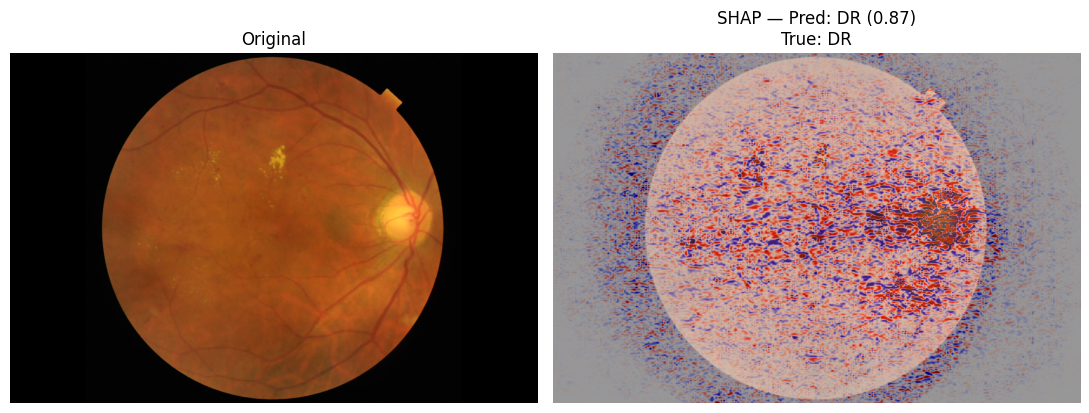

✅ Saved: C:\datasets\eye_project\models\reports\densenet121_shap\1133_shap_DR.png


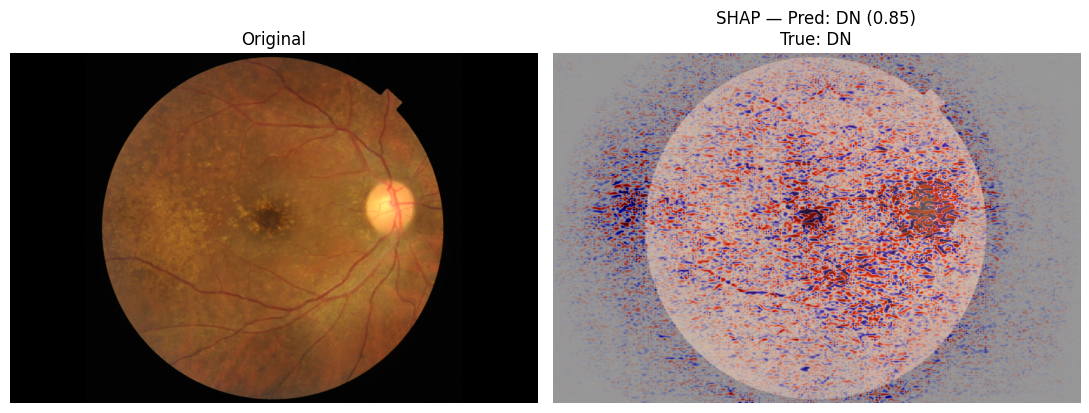

✅ Saved: C:\datasets\eye_project\models\reports\densenet121_shap\278_shap_DN.png


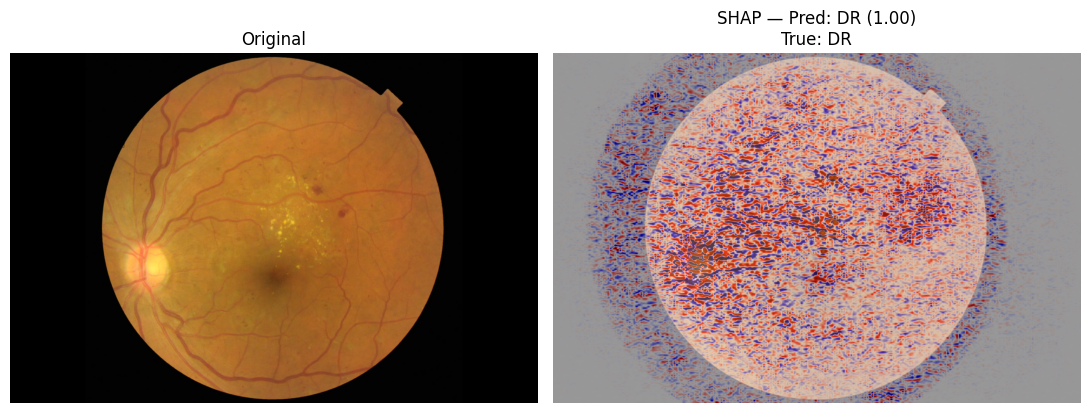

✅ Saved: C:\datasets\eye_project\models\reports\densenet121_shap\44_shap_DR.png


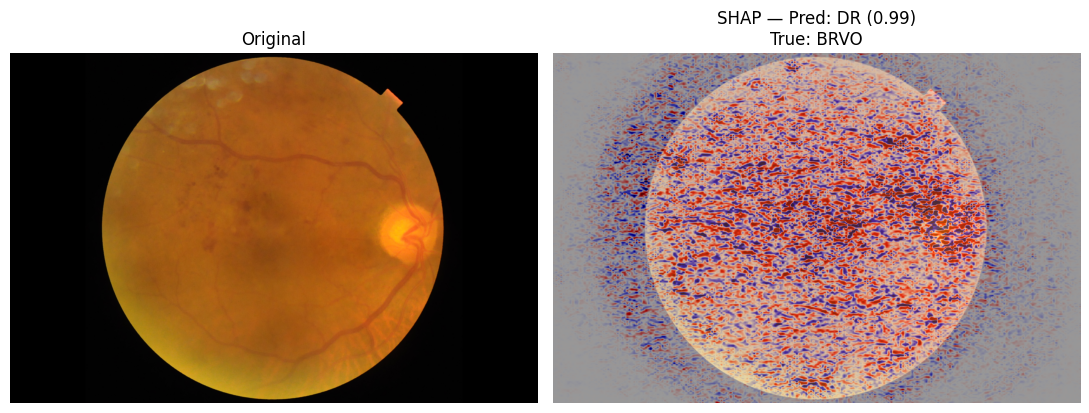

✅ Saved: C:\datasets\eye_project\models\reports\densenet121_shap\1361_shap_DR.png
✅ Done.


In [8]:
# ========================= SHAP XAI for DenseNet121 (robust + orig-size overlay) =========================
import sys, subprocess, warnings, os
warnings.filterwarnings("ignore")

# --- Install SHAP if missing ---
try:
    import shap
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import timm
from pathlib import Path
from PIL import Image, ImageFile
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Handle occasional truncated JPEGs
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --------------------------------------- Config ---------------------------------------
CLASSES     = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT       = Path(r"C:\datasets\eye_project")
CKPT_PATH  = ROOT / "models" / "densenet121_best.pth"             # <-- your trained weights
TEST_CSV   = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR    = ROOT / "models" / "reports" / "densenet121_shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE     = (224, 224)       # must match training
K_SAMPLES    = 4                # how many test images to explain
NSAMPLES     = 300              # SHAP sampling budget (↑ smoother, ↓ faster)
TARGET_LABEL = None             # e.g. "DR" to force that class, else None = explain top-pred

print("Device:", DEVICE)
assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"
assert TEST_CSV.exists(),  f"Test CSV not found: {TEST_CSV}"

# --------------------------------------- Model ---------------------------------------
model = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.to(DEVICE).eval()
print("✅ Loaded:", CKPT_PATH)

# Softmax wrapper so SHAP explains probabilities
class ProbWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.sm = torch.nn.Softmax(dim=1)
    def forward(self, x):
        return self.sm(self.base(x))

wrapped = ProbWrapper(model).to(DEVICE).eval()

# --------------------------------------- Preprocessing ---------------------------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
preproc = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

def load_tensor(path_str: str):
    pil = Image.open(path_str).convert("RGB")
    return preproc(pil), pil

# --------------------------------------- Helpers ---------------------------------------
def shap_to_hwc_safe(sv_block: np.ndarray) -> np.ndarray:
    """
    Convert a single-sample SHAP array to HWC robustly.
    Handles (3,H,W), (H,W,3), (3,H,W,1), (H,W), etc.
    """
    sv = np.array(sv_block)
    sv = np.squeeze(sv)  # remove size-1 dims e.g. (...,1)

    # (3,H,W) -> (H,W,3)
    if sv.ndim == 3 and sv.shape[0] == 3:
        sv = np.transpose(sv, (1, 2, 0))
    # (H,W) -> (H,W,3)
    elif sv.ndim == 2:
        sv = np.stack([sv, sv, sv], axis=-1)
    # If still 3D but channel not last, move channel to last
    elif sv.ndim == 3 and sv.shape[-1] != 3:
        sv = np.moveaxis(sv, 0, -1)

    # Final sanity: ensure HWC
    assert sv.ndim == 3 and sv.shape[-1] == 3, f"Unexpected SHAP shape after cleanup: {sv.shape}"
    return sv.astype(np.float32)

def overlay_diverging_on_original(pil_img: Image.Image, sv_hwc_224: np.ndarray, alpha=0.6):
    """
    Resize SHAP (HWC at 224x224) to original fundus size, build signed map (mean across RGB),
    colorize with a diverging colormap, overlay on original.
    """
    W, H = pil_img.size

    # Resize each channel in float mode to avoid PIL dtype issues
    sv_resized = np.stack([
        np.array(
            Image.fromarray(sv_hwc_224[..., c].astype(np.float32), mode="F").resize((W, H), Image.BILINEAR)
        )
        for c in range(3)
    ], axis=-1)  # (H,W,3), float

    signed = sv_resized.mean(axis=2)                      # (H,W)
    vmax = np.percentile(np.abs(signed), 99) + 1e-8       # robust scaling
    signed = np.clip(signed / vmax, -1.0, 1.0)            # -> [-1,1]

    cmap = cm.get_cmap("seismic")                         # blue neg, red pos
    colored = cmap((signed + 1) / 2.0)[..., :3]           # (H,W,3)
    base = (np.array(pil_img).astype(np.float32) / 255.0)

    overlay = np.clip((1 - alpha) * base + alpha * colored, 0, 1)
    return (overlay * 255).astype(np.uint8)

# --------------------------------------- Data ---------------------------------------
df = pd.read_csv(TEST_CSV)
df["img_path"] = df["img_path"].astype(str)
df = df[df["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
assert len(df) > 0, "Test CSV has no existing img_path rows."

# --------------------------------------- SHAP Background ---------------------------------------
BKG_N = min(25, len(df))
bkg_paths = df.sample(BKG_N, random_state=42)["img_path"].tolist()

bkg_tensors = []
for p in bkg_paths:
    try:
        xt, _ = load_tensor(p)
        bkg_tensors.append(xt)
    except Exception:
        pass
assert len(bkg_tensors) > 0, "No background images could be loaded for SHAP!"
background = torch.stack(bkg_tensors, dim=0).to(DEVICE)

# --------------------------------------- Explainer ---------------------------------------
explainer = shap.GradientExplainer(wrapped, background)

# --------------------------------------- Explain K samples ---------------------------------------
sample_df = df.sample(min(K_SAMPLES, len(df)), random_state=7).reset_index(drop=True)

for _, row in sample_df.iterrows():
    path = row["img_path"]
    true_label = row.get("label", "?")

    try:
        # Forward
        xt, pil = load_tensor(path)          # (3,224,224) preprocessed
        xb = xt.unsqueeze(0).to(DEVICE)      # (1,3,224,224)
        with torch.no_grad():
            probs = wrapped(xb)[0].detach().cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_lbl = CLASSES[pred_idx]
        conf = float(probs[pred_idx])

        # SHAP values
        if TARGET_LABEL is None:
            shap_values = explainer.shap_values(xb, ranked_outputs=1, nsamples=NSAMPLES)
            sv_raw = shap_values[0][0]                   # one image
        else:
            tgt_idx = CLASSES.index(TARGET_LABEL)
            shap_values = explainer.shap_values(xb, ranked_outputs=None, nsamples=NSAMPLES)
            sv_raw = shap_values[tgt_idx][0]

        sv_hwc = shap_to_hwc_safe(sv_raw)               # (224,224,3) float
        overlay = overlay_diverging_on_original(pil, sv_hwc, alpha=0.6)

        # Plot & save
        title = (f"SHAP — Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}"
                 if TARGET_LABEL is None else
                 f"SHAP — Target: {TARGET_LABEL} | Pred: {pred_lbl} ({conf:.2f})\nTrue: {true_label}")

        fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))
        ax[0].imshow(pil);     ax[0].set_title("Original"); ax[0].axis("off")
        ax[1].imshow(overlay); ax[1].set_title(title);      ax[1].axis("off")
        plt.tight_layout()

        stem = Path(path).stem
        suffix = TARGET_LABEL if TARGET_LABEL is not None else pred_lbl
        out_path = OUT_DIR / f"{stem}_shap_{suffix}.png"
        plt.savefig(out_path, dpi=220, bbox_inches="tight")
        plt.show()
        print(f"✅ Saved: {out_path}")

    except Exception as e:
        print(f"[WARN] Skipped {path}: {e}")

print("✅ Done.")
